In [150]:
import pandas as pd

url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=["label", "message"])

In [151]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [152]:
import unicodedata
import sys
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Creating set of stop-words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Creating dictionary for clean data from puctuation
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))

# Creating capitalizer func to preprocess text data
def preprocess_text(text):
    if isinstance(text, str): 
        text = text.strip() # deleting spaces
        text = text.lower() # lowercase
        text = text.translate(punctuation) # clear punctuation
        words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words] # delete stop words
        return ' '.join(words)  
    return ''  

data['cleaned_message'] = data['message'].apply(preprocess_text) #creatint new column with cleaned messages



data.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [153]:
data.describe()

,label,message,cleaned_message
count,5572,5572,5572
unique,2,5169,5117
top,ham,"Sorry, I'll call later",sorry ill call later
freq,4825,30,30


In [154]:
data_cleaned = data.drop_duplicates(subset=['cleaned_message']) #deleting duplicates
data_cleaned.head()

,label,message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [155]:
data_dcleanned = data_cleaned.drop('message', axis=1) # deleting 'message'
data_dcleanned.head()


,label,cleaned_message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


In [156]:
data_dcleanned.describe()


,label,cleaned_message
count,5117,5117
unique,2,5117
top,ham,go jurong point crazy available bugis n great ...
freq,4485,1


In [157]:
data['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

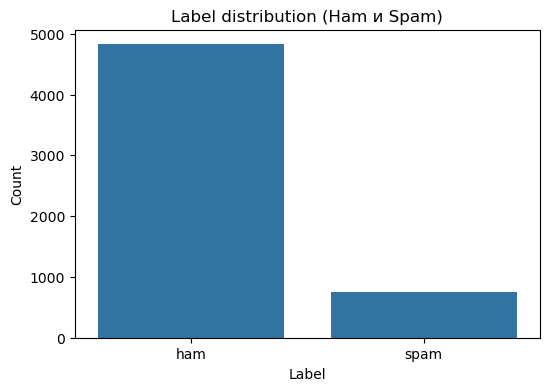

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 4)) #creating histogramm
sns.countplot(x='label', data=data) 
plt.title('Label distribution (Ham и Spam)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [159]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, Input

# Set a seed for the pseudo-random number generator to ensure reproducibility
np.random.seed(0)

# Create a Bag of Words (BoW) using CountVectorizer
# Using the top 400 most frequent words, with a binary presence indicator
vectorizer = CountVectorizer(max_features=400, binary=True)
features = vectorizer.fit_transform(data['cleaned_message'])

# Check the size of the feature matrix
print("Feature matrix size:", features.shape)  # Expected: (number of messages, 400)

# Encode the labels to (0, 1)
encoder = LabelEncoder()
targets = encoder.fit_transform(data['label'])

# Split the data into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)

# Convert sparse matrices to dense numpy arrays
features_train = features_train.toarray()
features_test = features_test.toarray()

# Set the number of features (expected to be 400)
number_of_features = features_train.shape[1]

# Initialize the neural network model
network = models.Sequential()

# Add input layer
network.add(Input(shape=(number_of_features,)))

# Add fully connected (Dense) layers with ReLU activation
network.add(layers.Dense(units=16, activation="relu"))
network.add(layers.Dense(units=16, activation="relu"))

# Add a fully connected output layer with sigmoid activation
network.add(layers.Dense(units=1, activation="sigmoid"))

# Compile the model with binary crossentropy loss and RMSProp optimizer
network.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

# Train the neural network
history = network.fit(
    features_train,
    targets_train,
    epochs=23,
    verbose=1,
    batch_size=100,
    validation_data=(features_test, targets_test))


Feature matrix size: (5572, 400)
Epoch 1/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8000 - loss: 0.6312 - val_accuracy: 0.8691 - val_loss: 0.4681
Epoch 2/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8747 - loss: 0.4136 - val_accuracy: 0.9157 - val_loss: 0.2908
Epoch 3/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9237 - loss: 0.2537 - val_accuracy: 0.9543 - val_loss: 0.1848
Epoch 4/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9597 - loss: 0.1569 - val_accuracy: 0.9641 - val_loss: 0.1309
Epoch 5/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9734 - loss: 0.1053 - val_accuracy: 0.9686 - val_loss: 0.1042
Epoch 6/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9762 - loss: 0.0832 - val_accuracy: 0.9713 - val_loss: 0.0936
Epoch 7/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9782 - loss: 0.0724 - val_accuracy: 0.9749 - val_loss: 0.0868
Epoch 8/23
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9823 - loss: 0.0651 -

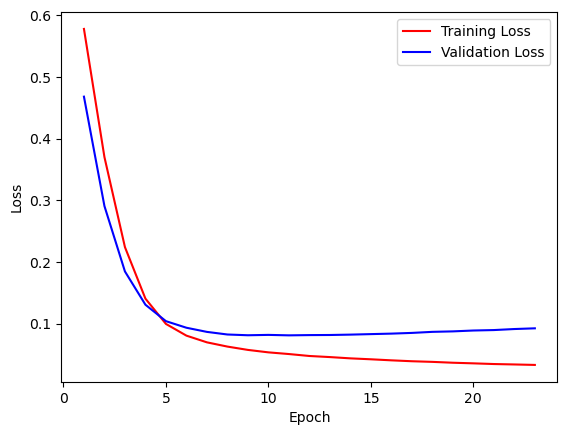

In [160]:
# Retrieve training and testing loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create a counter for the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize the loss history
plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


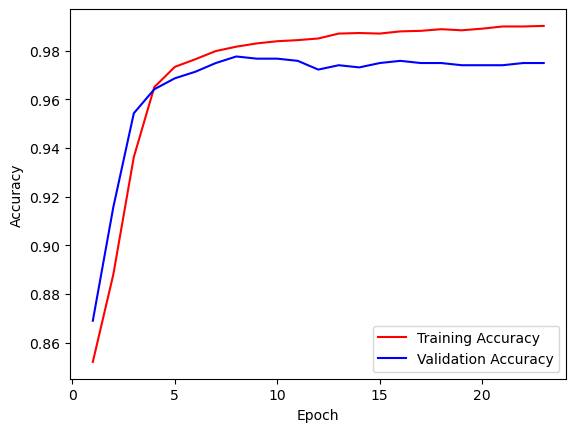

In [161]:
# Retrieve training and testing accuracy history
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.plot(epoch_count, training_accuracy, "r-")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize the accuracy history
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show();



In [187]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=400)  # Limit to the 400 most common words
tokenizer.fit_on_texts(data['cleaned_message'])

# Convert the texts to sequences of integers
sequences = tokenizer.texts_to_sequences(data['cleaned_message'])

# Pad the sequences to ensure they are all the same length
max_sequence_length = 800  # You can set this to the maximum length of your sequences
features = pad_sequences(sequences, maxlen=max_sequence_length)

encoder = LabelEncoder()
targets = encoder.fit_transform(data['label'])

# Split the data into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)

network = models.Sequential()

# Add an embedding layer
network.add(layers.Embedding(input_dim=number_of_features, output_dim=32))

# Add an LSTM layer with 128 units (Long Short-Term Memory)
network.add(layers.LSTM(units=32))

# Add a fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation="sigmoid"))

# Compile the neural network
network.compile(
    loss="binary_crossentropy",  # Cross-entropy loss
    optimizer="Adam",  # Adam optimizer
    metrics=["accuracy"]  # Accuracy metric
)

# Train the neural network
history = network.fit(
    features_train,  # Features
    targets_train,  # Targets
    epochs=10,  # Number of epochs
    verbose=1,  # Do not print the description after each epoch
    batch_size=100,  # Number of samples per batch
    validation_data=(features_test, targets_test)  # Test data
)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.8556 - loss: 0.4732 - val_accuracy: 0.8789 - val_loss: 0.2799
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.8988 - loss: 0.2552 - val_accuracy: 0.9552 - val_loss: 0.1644
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9634 - loss: 0.1318 - val_accuracy: 0.9740 - val_loss: 0.1066
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9775 - loss: 0.1000 - val_accuracy: 0.9803 - val_loss: 0.0844
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9807 - loss: 0.0713 - val_accuracy: 0.9803 - val_loss: 0.0755
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.9802 - loss: 0.0619 - val_accuracy: 0.9794 - val_loss: 0.0710
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - accuracy: 0.9830 - loss: 0.0598 - val_accuracy: 0.9776 - val_loss: 0.0724
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.9850 - loss: 0.0490 - val_accuracy: 0

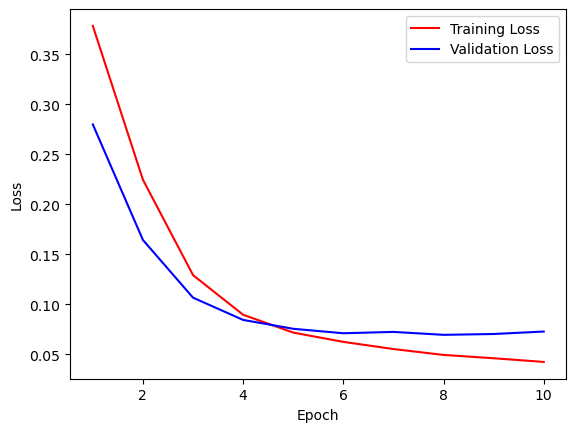

In [189]:
# Retrieve training and testing loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

# Create a counter for the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize the loss history
plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

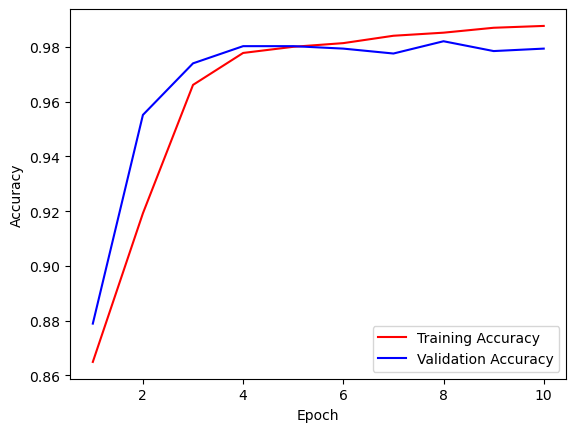

In [191]:
# Retrieve training and testing accuracy history
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]

plt.plot(epoch_count, training_accuracy, "r-")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize the accuracy history
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show();